<h1><center>Ingénierie Mathématique 3, Devoir Maison</center></h1>
<h1><center>Janvier 2025</center></h1>

<h3><center>Total: 15 points<br>
    <br>
    Début: 1 Janvier 2025<br>
    <br>
    Fin: 24 Janvier 2025</center></h3>
    
   
<h3><font color='red'>Consignes:</font></h3>

<font color='red'>Aucun devoir soumis après le 20 janvier ne sera pris en compte. Les devoirs qui ne respectent pas strictement les consignes reprises sur le site web (http://www.augustincosse.com/wp-content/uploads/2023/03/consignesSoumission2.pdf) ne seront pas pris en compte. En particulier, la soumission consistera en un __unique__ fichier ".ipynb" envoye par email dans un email dont l'objet sera "INFO2 Ingenierie Math DM"
</font>

## Question 1 (5pts) Un premier modèle

On considère le jeu de données MNIST ci-dessous (les images peuvent être téléchargées via scikit learn ou via keras). On souhaite commencer par entraîner un modèle de régression logistique permettant de différencier les 1 des 0. Pour ce faire on procédera comme suit:

- Extraire à partir des données ci-dessous, les images représentant des $1$ ou des $0$.
- Séparer les données en un ensemble de test et un ensemble d'entraînement (on gardera 10% des données pour l'ensemble test)
- Compléter la fonction "binary_cross_entropy" afin que celle-ci retourne la valeur de l'entropie binaire croisée ainsi que le gradient de cette fonction en une image donnée et pour un vecteur de coefficients de régression $\mathbf{w}$ donne.
- Compléter ensuite la fonction “optimisation" afin qu'elle implémente une descente de gradient sur la fonction d'entropie binaire croisée. On souhaite  renvoyer en sortie le vecteur des coefficients de régression ainsi que (1) le taux de classification (en pourcentage de données correctement classées sur le nombre de données totales) sur les ensembles d'entraînement et de test.  



In [3]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Charger les données MNIST (les images + les labels)

In [53]:
X_old, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [54]:
# Filtrer pour ne garder que les classes 0 et 1
X_old = X_old[(y == '0') | (y == '1')]
y = y[(y == '0') | (y == '1')].astype(int)

In [55]:
X_old.shape

(14780, 784)

In [56]:
y = y.astype(int)

$X$ c'est une matrice de 14780 lignes (images) et de 784 colones (28x28).

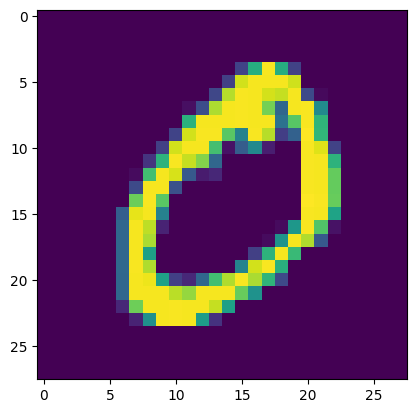

In [57]:
# visualisé la première image
plt.imshow(X_old[0].reshape(28,28))

In [58]:
# Afficher le label corespondant
y[0]

0

### Normalisé les images:

In [59]:
X_old.max(), X_old.min()

(255, 0)

$$X_{norm} = \frac{(X - X_{min})}{(X_{max} - X_{min})} = \frac{X}{255}$$

In [60]:
# X = (X_old - X_old.min())/(X_old.max() - X_old.min())

X = X_old/255

In [61]:
X.max(), X.min()

(1.0, 0.0)

### Séparer les données

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [63]:
X_train.shape, y_train.shape

((13302, 784), (13302,))

In [64]:
X_test.shape, y_test.shape

((1478, 784), (1478,))

### Definir le modèle de régression logistique

In [65]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [66]:
def logistic_regression(X, w):
    return sigmoid(np.dot(X, w))

In [67]:
# Exemple avec une seule image

W = np.random.rand(784, 1)

image = X_train[0]

y_pred = logistic_regression(image, W)
print(y_pred)

[1.]


In [68]:
# Exemple avec une 3 images

W = np.random.rand(784, 1)

image = X_train[0:3]

y_pred = logistic_regression(image, W)
print(y_pred)

[[1.]
 [1.]
 [1.]]


### Calculer `binary_cross_entropy`

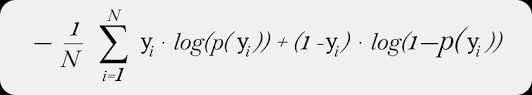

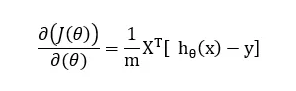

Pour compléter la fonction suivante, nous avons besoin de la formule de l'entropie croisée binaire (BCE) ainsi que de sa dérivée par rapport à W. Voici un article sur Medium qui explique les étapes pour calculer cette dérivée.

https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d

In [69]:
def binary_cross_entropy(X, y, w):
    '''
    la fonction doit calculer la valeur de l'entropie binaire croisée
    l(w) = - sum_i t_i*log(sigma(y(x_i))) + (1-t_i)*log(1-sigma(y(x_i)))
    ainsi que le gradient de cette fonction
    '''

    predictions = logistic_regression(X, w)

    bce_fun = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))

    bce_grad = -np.dot(X.T, (y - predictions)) / X.shape[0]
    bce_grad = np.mean(bce_grad, axis=-1)
    #
    return bce_fun, bce_grad

In [70]:
# Exemple

images = X_train[:10]
labels = y_train[:10]
weights = np.random.rand(images.shape[1], 1)

bce, bce_grad = binary_cross_entropy(images, labels, weights)
print("BCE:", bce)
print("Gradient BCE:\n", bce_grad[50:70])
print("shape Grad BCE", bce_grad.shape)

BCE: 15.510246808657262
Gradient BCE:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
shape Grad BCE (784,)


### Compléter la fonction "optimisation"

In [71]:
def classification_rate(X, y, w):
    predictions = logistic_regression(X, w) >= 0.5
    return np.mean(predictions == y) * 100

In [84]:
def optimisation(w_init, eta, X, y, n_iter=2, batch_size=32, verbose_int=100):
    """
    Descente de gradient pour la régression logistique.
    """
    w_opt = w_init

    for i in range(n_iter):
        bce_loss = 0
        for idx in range(0, X.shape[0] - batch_size, batch_size):

            X_i = X[idx:idx+batch_size]
            y_i = y[idx:idx+batch_size]

            bce_fun, bce_grad = binary_cross_entropy(X_i, y_i, w_opt)

            bce_loss += bce_fun

            w_opt -= eta * bce_grad.reshape(-1, 1)

        if i % verbose_int == 0:
            print("Epoch:", i)
            print("bce loss:", bce_loss)

    # Calculer les taux de classification sur l'ensemble d'entraînement et de test
    rate_bce_training = classification_rate(X, y, w_opt)
    rate_bce_test = classification_rate(X_test, y_test, w_opt)

    return w_opt, rate_bce_training, rate_bce_test

In [86]:
# Appeler la fonction d'optimisation

W_init = np.random.rand(X.shape[1], 1)
eta = 0.001
w_opt, rate_bce_training, rate_bce_test = optimisation(
    W_init, eta, X_train, y_train, n_iter=1000, batch_size=32)

Epoch: 0
bce loss: 6089.401080302855
Epoch: 100
bce loss: 325.3985982862328
Epoch: 200
bce loss: 307.2073731004193
Epoch: 300
bce loss: 300.33367632076613
Epoch: 400
bce loss: 296.75941297198534
Epoch: 500
bce loss: 294.6054615968622
Epoch: 600
bce loss: 293.1721414393053
Epoch: 700
bce loss: 292.1507278742132
Epoch: 800
bce loss: 291.3863392913626
Epoch: 900
bce loss: 290.7928906716861


In [87]:
train_accuracy = classification_rate(X_train, y_train, w_opt)

print("Train accuracy:", train_accuracy)

Train accuracy: 51.921124927748


## Question 2 (5pts) Un petit réseau convolutif

On souhaite à présent ameliorer le resultat de la question 1 a l'aide d'un réseau convolutionnel. Pour ce faire, on souhaite utiliser la librairie Keras (voir https://keras.io/) et en particulier, le modele de reseau convolutionnel (https://keras.io/api/layers/convolution_layers/). Un réseau convolutionnel fonctionne en "filtrant" les images à l'aide de différents filtres dont les coefficients sont appris lors de l'étape d'entraînement. Un réseau convolutionnel efficace est typiquement constitué d'une succession de couches convolutives et de pooling (voir par exemple https://www.tensorflow.org/tutorials/images/cnn).

Chaque couche convolutive déplace un filtre (dont les coefficients sont fixés lors de l'étape d'entraînement) sur les sorties des couches précédentes


<img src="same_padding_no_strides.gif" alt="stackoverflow.com" width=304 height=142>


Afin de réduire la dimension des sorties des couches successives, on alterne généralement entre des couches convolutives et des couches de pooling (équivalentes à un sous-échantillonnage) qui retiennent pour une région donnée, uniquement les pixels de plus forte intensité (afin de conserver une trace du contraste). Ces couches sont de la forme suivante:


<img src="maxPool.png" alt="stackoverflow.com" width=504 height=142>


En utilisant le modele Sequential() de keras et la fonction add() permettant d'ajouter des couches convolutionnelles ou de pooling, ainsi que la fonction compile() permettant d'entrainer le reseau, et en vous aidant de la documentation de tensorFlow (https://www.tensorflow.org/tutorials/images/cnn), entrainer un (petit) reseau convolutionnel sur les images 0 et 1 des donnees MNIST de la question 1 (A nouveau, on retiendra environ 10% de donnees pour l'ensemble test).

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [90]:
X = X_old.reshape(-1, 28, 28)
y = y.reshape(-1, 1)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [92]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [97]:
model = Sequential([])

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

In [98]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,002 (875.01 KB)

 Trainable params: 224,002 (875.01 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [100]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.9695 - loss: 1.5934 - val_accuracy: 0.9993 - val_loss: 0.0249
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9992 - loss: 0.0103 - val_accuracy: 0.9966 - val_loss: 0.0519
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9979 - loss: 0.0229 - val_accuracy: 0.9993 - val_loss: 6.1373e-04
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9996 - loss: 0.0033 - val_accuracy: 0.9986 - val_loss: 0.0295
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9986 - val_loss: 0.0136
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 1.0000 - loss: 1.1008e-08 - val_accuracy: 0.9986 - val_loss: 0.0144
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 1.0000 - loss: 4.5880e-09 - val_accuracy: 0.9986 - val_loss: 0.0142
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 1.0000 - los

In [101]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"Taux de classification sur l'ensemble d'entraînement : {train_acc * 100:.2f}%")
print(f"Taux de classification sur l'ensemble de test : {test_acc * 100:.2f}%")

Taux de classification sur l'ensemble d'entraînement : 100.00%
Taux de classification sur l'ensemble de test : 99.86%


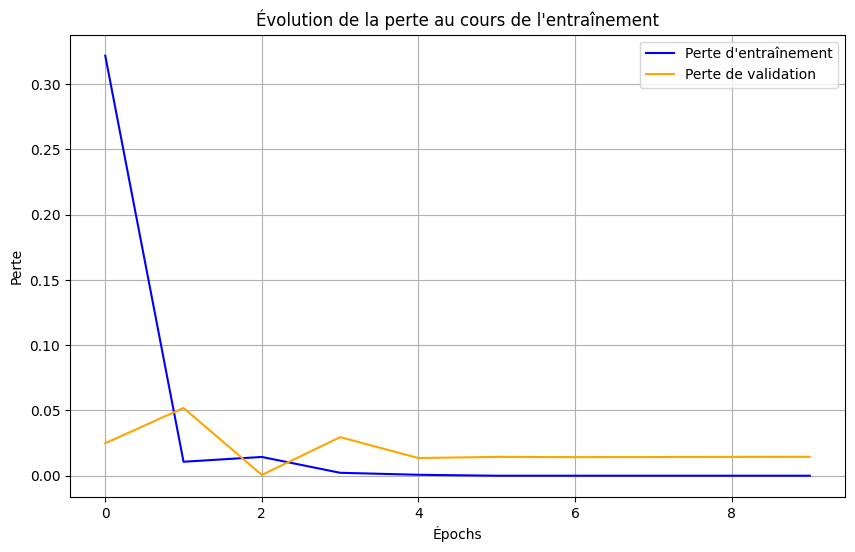

In [102]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Tracer les courbes
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Perte d\'entraînement', color='blue')
plt.plot(val_loss, label='Perte de validation', color='orange')
plt.title('Évolution de la perte au cours de l\'entraînement')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)
plt.show()

## Question 3 (5pts) Astuce du Noyau

On souhaite à présent entraîner un modèle de régression linéaire dans l'espace noyau sur les images de 0 et de 1. Afin d'atteindre cet objectif, on procédera comme suit:

- Sélectionner un sous-ensemble d'équilibre d'images de 0 et de 1 (on commencera par exemple par prendre 50 images du chiffre 0 et 50 images du chiffre 1).
- Compléter la fonction G(x, y) qui renvoie la valeur d'un noyau Gaussien de paramètre sigma, aux points $x$ et $y$.
- Compléter la fonction "optimize" a l'aide d'une descente de gradient dans l'espace noyau afin qu'elle retourne le vecteur des coefficients $\lambda_j$ d'un modele du type
$$y(x) = \sum_{j=1}^N \lambda_j G(x, x_j)$$

- Comme pour la question 2, on souhaite implémenter la fonction "optimize" de façon à ce qu'elle retourne la liste des taux de classification correcte (sur l' ensemble d'entraînement et de test) pour chacune des itérations.


$$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$$
$$ G(x, x_j) = \exp\left(-\frac{\norm{x-x_j}}{2σ^2}\right)$$

In [104]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))

In [105]:
def G(x, y, sigma):

    '''La fonction doit renvoyer la valeur du noyeau gaussien de
    variance sigma aux points x et y'''

    return gaussian_kernel(x, y, sigma=sigma)

In [106]:
# Exemple

gk = G(np.array([1, 2]), np.array([3, 4]), sigma=1)
print(gk)

0.018315638888734165


In [107]:
# Matrice de noyau pour un ensemble X
def compute_kernel_matrix(X, sigma=1.0):
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = gaussian_kernel(X[i], X[j], sigma)
    return K

In [108]:
compute_kernel_matrix(X_train[:5])

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [109]:
def optimize(X_train, y_train, X_test, y_test, sigma=1.0, eta=0.01, n_iterations=100):
    n_samples = X_train.shape[0]
    K = compute_kernel_matrix(X_train, sigma)
    lbda = np.zeros(n_samples)

    train_accuracies = []
    test_accuracies = []

    for iteration in range(n_iterations):
        # Calcul de la prédiction sur l'ensemble d'entraînement
        y_pred_train = np.dot(K, lbda)
        y_pred_train = 1 / (1 + np.exp(-y_pred_train))  # Sigmoïde

        # Calcul du gradient
        gradient = np.dot(K.T, (y_pred_train - y_train))

        # Mise à jour des coefficients λj
        lbda -= eta * gradient

        # Prédictions sur les ensembles d'entraînement et de test
        y_train_pred = (np.dot(K, lbda) > 0.5).astype(int)
        K_test = np.array([[gaussian_kernel(x, x_train, sigma) for x_train in X_train] for x in X_test])
        y_test_pred = (np.dot(K_test, lbda) > 0.5).astype(int)

        # Calcul des taux de classification correcte
        train_acc = np.mean(y_train_pred == y_train)
        test_acc = np.mean(y_test_pred == y_test)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    rate_training = train_accuracies
    rate_test = test_accuracies

    return lbda, rate_training, rate_test

In [ ]:
sigma = 1.0
eta = 0.01
n_iterations = 2
lambdas, train_accuracies, test_accuracies = optimize(X_train, y_train, X_test, y_test, sigma, eta, n_iterations)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label="Taux d'entraînement", color='blue')
plt.plot(test_accuracies, label="Taux de test", color='orange')
plt.title("Évolution des taux de classification correcte")
plt.xlabel("Itérations")
plt.ylabel("Taux de classification")
plt.legend()
plt.grid(True)
plt.show()